<a href="https://colab.research.google.com/github/micah-shull/pipelines/blob/main/pipelines_1703_feature_selection_10_hybrid_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Summary of the Hybrid Feature Selection Pipeline:

This pipeline implements a multi-stage feature selection process by combining filter, wrapper, and embedded methods:

1. **Preprocessing**:
   - The data is preprocessed using a `ColumnTransformer` that handles both numerical and categorical features. Numerical features are imputed and scaled, while categorical features are imputed and one-hot encoded.

2. **SMOTE (Synthetic Minority Over-sampling Technique)**:
   - SMOTE is applied to the preprocessed data to address class imbalance by oversampling the minority class.

3. **Filter Methods**:
   - **Variance Threshold**: Removes features with low variance (below 0.01). This step is crucial for quickly discarding features that do not vary much and are therefore unlikely to be informative.
   - **Univariate Feature Selection (SelectKBest with Mutual Information)**: Selects the top 20 features based on mutual information, focusing on features most correlated with the target variable.

4. **Wrapper Methods**:
   - **Recursive Feature Elimination (RFE)**: Iteratively selects features based on model performance, starting with all features and removing the least important ones until the optimal subset is identified.

5. **Embedded Methods**:
   - **SelectFromModel with RandomForestClassifier**: Final feature selection is performed using a tree-based model that ranks features based on their importance in the model.

6. **Classification**:
   - The final model uses Logistic Regression with a custom threshold of 0.3 to improve the focus on specific classes (e.g., higher recall for the minority class).

### Why Using a Pipeline Is Beneficial:

1. **Consistency and Reproducibility**:
   - A pipeline ensures that all preprocessing, feature selection, and model training steps are applied consistently every time, reducing the chances of errors and improving reproducibility.

2. **Modularity and Reusability**:
   - Each step of the pipeline is modular, making it easy to adjust or replace components (e.g., swapping out `SelectKBest` for a different method). This modularity allows for quick experimentation without rewriting the entire process.

3. **Ease of Hyperparameter Tuning**:
   - Pipelines integrate seamlessly with tools like `GridSearchCV`, enabling hyperparameter tuning across all stages of the process (e.g., number of features to select in RFE). This centralizes tuning and simplifies optimization.

4. **Streamlined Workflows**:
   - By chaining steps together, pipelines reduce the need to manually track and pass data between each stage. This is especially useful when complex transformations and selections are involved, ensuring everything is automated.

5. **Built-In Cross-Validation**:
   - Pipelines naturally support cross-validation, ensuring that the entire process, including feature selection, is cross-validated, preventing data leakage and giving more reliable performance metrics.

6. **Documentation and Clarity**:
   - The pipeline structure is easy to document and understand. Each step is clearly defined, making it simpler for others to follow and reproduce the process. It also provides a single source of truth for the end-to-end workflow.

This pipeline efficiently combines multiple feature selection methods to progressively narrow down the feature set, ensuring the final model is trained on the most relevant and impactful features, all while leveraging the strengths of each method.

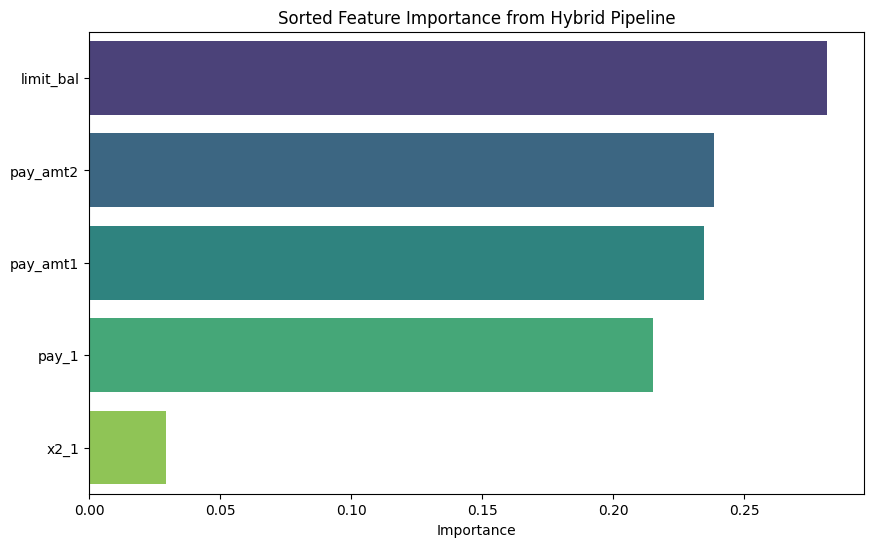

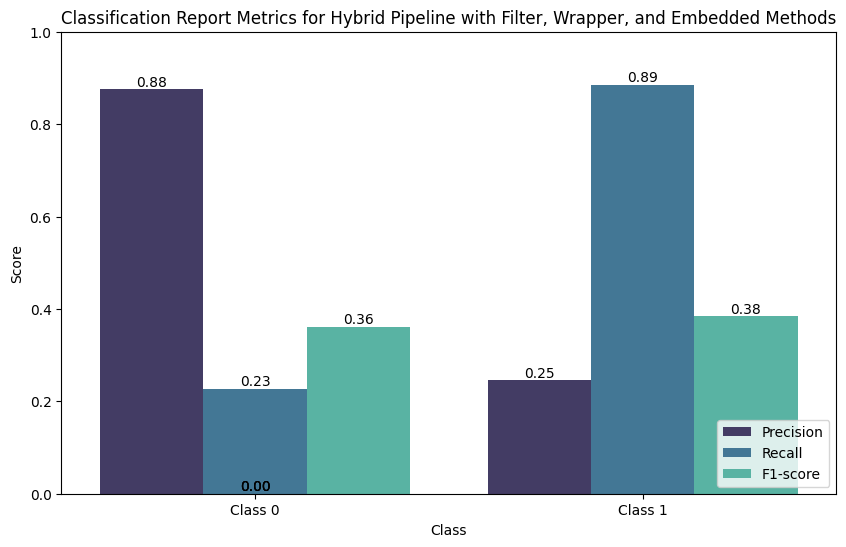

Classification report saved to 'classification_reports_hybrid_methods.json'
Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.23      0.36      4673
           1       0.25      0.89      0.38      1327

    accuracy                           0.37      6000
   macro avg       0.56      0.56      0.37      6000
weighted avg       0.74      0.37      0.37      6000



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif, SelectFromModel
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV, StratifiedKFold
import joblib
import json
import warnings
from loan_data_utils import load_and_preprocess_data, plot_classification_report_metrics, plot_selected_features, ThresholdClassifier

# Suppress warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Define your URL, categorical columns, and target
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls"
categorical_columns = ['sex', 'education', 'marriage']
target = 'default_payment_next_month'

# Load and preprocess data
X, y = load_and_preprocess_data(url, categorical_columns, target)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Identify numeric and categorical columns
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['category']).columns.tolist()

# Define the column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), numeric_features),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OneHotEncoder(drop='first'))
        ]), categorical_features)
    ])

# Use the custom classifier with Logistic Regression and a threshold of 0.3 for class 1
base_classifier = LogisticRegression(max_iter=3000)
classifier = ThresholdClassifier(base_classifier, threshold=0.3)

# Set up the pipeline with filter, wrapper, and embedded methods
hybrid_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),  # Preprocessing step (imputer, scaler, encoder)
    ('smote', SMOTE(random_state=42)),  # Apply SMOTE
    # Filter stage: Variance Thresholding and SelectKBest (using mutual_info_classif)
    ('var_thresh', VarianceThreshold(threshold=0.01)),
    ('select_kbest', SelectKBest(mutual_info_classif, k=20)),  # Replace chi2 with mutual_info_classif
    # Wrapper stage: Recursive Feature Elimination (RFE)
    ('rfe', RFE(estimator=base_classifier, n_features_to_select=10)),
    # Embedded stage: SelectFromModel using a RandomForest classifier
    ('select_from_model', SelectFromModel(RandomForestClassifier(n_estimators=100, random_state=42))),
    # Final classification step with threshold adjustment
    ('classifier', classifier)
])

# Set up the parameter grid to tune the RFE stage
param_grid = {
    'rfe__n_features_to_select': np.linspace(5, 20, 5, dtype=int).tolist()  # Adjust based on your dataset
}

# Use StratifiedKFold for cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=hybrid_pipeline, param_grid=param_grid, cv=cv, scoring='recall', n_jobs=-1)

# Fit the grid search
grid_search.fit(X_train, y_train)  # Use X_train and y_train directly

# Get the best pipeline
best_pipeline = grid_search.best_estimator_

# Access the preprocessor and fitted feature selectors
preprocessor_fitted = best_pipeline.named_steps['preprocessor']
var_thresh_fitted = best_pipeline.named_steps['var_thresh']
select_kbest_fitted = best_pipeline.named_steps['select_kbest']
rfe_fitted = best_pipeline.named_steps['rfe']
select_from_model_fitted = best_pipeline.named_steps['select_from_model']

# Access and visualize feature importances from the embedded method (RandomForest)
feature_importances = select_from_model_fitted.estimator_.feature_importances_

# Get the feature names
numeric_feature_names = preprocessor_fitted.named_transformers_['num'].get_feature_names_out()
categorical_feature_names = preprocessor_fitted.named_transformers_['cat'].named_steps['encoder'].get_feature_names_out()
all_feature_names = np.concatenate([numeric_feature_names, categorical_feature_names])

# Apply the filter and wrapper steps to get the final selected features
filtered_features = all_feature_names[var_thresh_fitted.get_support()][select_kbest_fitted.get_support()][rfe_fitted.support_]

# Sort the selected features by their importance
sorted_indices = np.argsort(feature_importances)[::-1]
sorted_feature_names = filtered_features[sorted_indices]
sorted_feature_importances = feature_importances[sorted_indices]

# Plot the sorted combined selected features importance
plt.figure(figsize=(10, 6))
sns.barplot(x=sorted_feature_importances, y=sorted_feature_names, palette='viridis')
plt.xlabel('Importance')
plt.title('Sorted Feature Importance from Hybrid Pipeline')
plt.show()

# Plot the classification report metrics
y_pred = best_pipeline.predict(X_test)
report = classification_report(y_test, y_pred, output_dict=True)
plot_classification_report_metrics(report, 'Hybrid Pipeline with Filter, Wrapper, and Embedded Methods')

# Save the classification report to a JSON file
with open('classification_reports_hybrid_methods.json', 'w') as f:
    json.dump(report, f, indent=4)
print("Classification report saved to 'classification_reports_hybrid_methods.json'")

# Print the classification report
print("Test Set Classification Report:")
print(classification_report(y_test, y_pred))


#### Loand Data Utils

In [3]:
script_content=r'''
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
import joblib
import json
import logging
# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

#--------   Load and Preprocess Data   --------#

def load_data_from_url(url):
    try:
        df = pd.read_excel(url, header=1)
        logging.info("Data loaded successfully from URL.")
    except Exception as e:
        logging.error(f"Error loading data from URL: {e}")
        return None
    return df

def clean_column_names(df):
    df.columns = [col.lower().replace(' ', '_') for col in df.columns]
    return df

def remove_id_column(df):
    if 'id' in df.columns:
        df = df.drop(columns=['id'])
    return df

def rename_columns(df):
    rename_dict = {'pay_0': 'pay_1'}
    df = df.rename(columns=rename_dict)
    return df

def convert_categorical(df, categorical_columns):
    df[categorical_columns] = df[categorical_columns].astype('category')
    return df

def split_features_target(df, target):
    X = df.drop(columns=[target])
    y = df[target]
    return X, y

def load_and_preprocess_data(url, categorical_columns, target):
    df = load_data_from_url(url)
    if df is not None:
        df = clean_column_names(df)
        df = remove_id_column(df)
        df = rename_columns(df)
        df = convert_categorical(df, categorical_columns)
        X, y = split_features_target(df, target)
        return X, y
    return None, None

#--------   Plot Class Distribution   --------#


def plot_class_distribution(y_train, target_name):
    plt.figure(figsize=(8, 5))
    sns.countplot(x=y_train, hue=y_train, palette='mako')
    plt.title(f'Class Distribution in Training Set: {target_name}')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.legend([], [], frameon=False)

    # Calculate the percentage for each class
    total = len(y_train)
    class_counts = y_train.value_counts()
    for i, count in enumerate(class_counts):
        percentage = 100 * count / total
        plt.text(i, count, f'{percentage:.1f}%', ha='center', va='bottom')

    plt.show()

#--------   Custom Classifier   --------#

# Define a custom classifier to handle class-specific threshold
class ThresholdClassifier(BaseEstimator, TransformerMixin):
    def __init__(self, base_classifier, threshold=0.3):
        self.base_classifier = base_classifier
        self.threshold = threshold

    def fit(self, X, y):
        self.base_classifier.fit(X, y)
        return self

    def predict_proba(self, X):
        return self.base_classifier.predict_proba(X)

    def predict(self, X):
        proba = self.predict_proba(X)
        return (proba[:, 1] >= self.threshold).astype(int)


#--------   Evaluate and Capture Metrics   --------#

# Function to evaluate model
def evaluate_model(pipeline, X_train, X_test, y_train, y_test, model_name, experiment_name):
    logger.info(f"Training and evaluating model: {model_name} ({experiment_name})")

    # Fit the pipeline
    pipeline.fit(X_train, y_train)

    # Make predictions
    y_pred = pipeline.predict(X_test)

    # Capture classification report
    report = classification_report(y_test, y_pred, output_dict=True)

    # Extract relevant metrics
    metrics = {
        'Model': model_name,
        'Experiment': experiment_name,
        'Recall_0': report['0']['recall'],
        'Precision_0': report['0']['precision'],
        'F1_0': report['0']['f1-score'],
        'Recall_1': report['1']['recall'],
        'Precision_1': report['1']['precision'],
        'F1_1': report['1']['f1-score'],
        'F1_Macro': report['macro avg']['f1-score'],
        'Accuracy': report['accuracy']
    }
    return metrics


# #--------   Plot Classification Report  --------#

# Plotting function with annotations
def plot_classification_report_metrics(report, model_name):
    metrics_df = pd.DataFrame({
        'Class': ['Class 0', 'Class 0', 'Class 0', 'Class 1', 'Class 1', 'Class 1'],
        'Metric': ['Precision', 'Recall', 'F1-score', 'Precision', 'Recall', 'F1-score'],
        'Value': [
            report['0']['precision'],
            report['0']['recall'],
            report['0']['f1-score'],
            report['1']['precision'],
            report['1']['recall'],
            report['1']['f1-score']
        ]
    })

    plt.figure(figsize=(10, 6))
    ax = sns.barplot(x='Class', y='Value', hue='Metric', data=metrics_df, palette='mako')
    plt.title(f'Classification Report Metrics for {model_name}')
    plt.ylabel('Score')
    plt.ylim(0, 1)
    plt.legend(loc='lower right')

    # Annotate the bars with the values
    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f'{height:.2f}',
                    (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='center',
                    xytext=(0, 5),
                    textcoords='offset points')

    plt.show()

def plot_classification_report_thresholds(report, method_name, threshold):
    """
    Function to plot the precision, recall, and f1-score metrics for class 0 and class 1.
    """
    # Extract metrics from the report
    metrics_df = pd.DataFrame({
        'Class': ['Class 0', 'Class 0', 'Class 0', 'Class 1', 'Class 1', 'Class 1'],
        'Metric': ['Precision', 'Recall', 'F1-score', 'Precision', 'Recall', 'F1-score'],
        'Value': [
            report['0']['precision'],
            report['0']['recall'],
            report['0']['f1-score'],
            report['1']['precision'],
            report['1']['recall'],
            report['1']['f1-score']
        ]
    })

    # Plot the metrics
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Class', y='Value', hue='Metric', data=metrics_df, palette='mako')
    plt.title(f'Classification Report Metrics for {method_name} at Threshold {threshold}')
    plt.ylabel('Score')
    plt.ylim(0, 1)
    plt.legend(loc='lower right')
    plt.show()

# #--------   Plot Selected Features  --------#

def plot_selected_features(selected_features, model_name):
    features = list(selected_features.keys())
    importances = list(selected_features.values())
    plt.figure(figsize=(10, 8))
    sns.barplot(x=importances, y=features, palette='viridis')
    plt.title(f'Selected Features and their Importance for {model_name}')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.show()
'''

# Write the script to a file
with open("loan_data_utils.py", "w") as file:
    file.write(script_content)

print("Script successfully written to loan_data_utils.py")
# Reload script to make functions available for use
import importlib
import loan_data_utils
importlib.reload(loan_data_utils)

from loan_data_utils import *

Script successfully written to loan_data_utils.py
